## Compare DKN ability in function interpolation with MLP

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from KKANLayer import KKANLayer

In [15]:
# Define target function
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    mask2 = (0.5 <= x) & (x < 1.5)
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    mask3 = x >= 1.5
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])
    # add noise
    noise = np.random.normal(0, 0.2, y.shape)
    y += noise
    return y

In [16]:
# Define MLP
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x-1) # centralize the input

In [17]:
# Define KKANs
g = 60
class KKAN(nn.Module):
    def __init__(self):
        super(KKAN, self).__init__()
        self.KKAN1 = KKANLayer(1, 8, g)
        self.KKAN2 = KKANLayer(8, 1, g)

    def forward(self, x):
        x = self.KKAN1(x)
        x = self.KKAN2(x)
        return x

In [18]:
# Generate sample data
x_train = torch.linspace(0, 2, steps=500).unsqueeze(1)
y_train = torch.tensor(target_function(x_train))

/tmp/ipython-input-15-3883575799.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
/tmp/ipython-input-15-3883575799.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
/tmp/ipython-input-15-3883575799.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])


In [19]:
torch.manual_seed(42)

# Instantiate models
mlp_model = SimpleMLP()
kkan_model = KKAN()


# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.03)
optimizer_kkan = torch.optim.Adam(kkan_model.parameters(), lr=0.03)

mlp_losses = []
kkan_losses = []

# Train the models
epochs = 1500
for epoch in range(epochs):
    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train)
    loss_mlp = criterion(outputs_mlp, y_train)
    loss_mlp.backward()
    optimizer_mlp.step()

    optimizer_kkan.zero_grad()
    outputs_kkan = kkan_model(x_train)
    loss_kkan = criterion(outputs_kkan, y_train)
    loss_kkan.backward()
    optimizer_kkan.step()

    if epoch % 10 == 0:
        mlp_losses.append(loss_mlp.item())
        kkan_losses.append(loss_kkan.item())
        print(f'Epoch {epoch + 1}/{epochs}, MLP Loss: {loss_mlp.item():.4f}, KKAN Loss: {loss_kkan.item():.4f}')


Epoch 1/1500, MLP Loss: 0.5669, KKAN Loss: 0.8763
Epoch 11/1500, MLP Loss: 0.8319, KKAN Loss: 0.5071
Epoch 21/1500, MLP Loss: 0.4072, KKAN Loss: 0.3924
Epoch 31/1500, MLP Loss: 0.3631, KKAN Loss: 0.3058
Epoch 41/1500, MLP Loss: 0.2861, KKAN Loss: 0.2497
Epoch 51/1500, MLP Loss: 0.2604, KKAN Loss: 0.2385
Epoch 61/1500, MLP Loss: 0.2567, KKAN Loss: 0.2396
Epoch 71/1500, MLP Loss: 0.2536, KKAN Loss: 0.2375
Epoch 81/1500, MLP Loss: 0.2516, KKAN Loss: 0.2370
Epoch 91/1500, MLP Loss: 0.2511, KKAN Loss: 0.2378
Epoch 101/1500, MLP Loss: 0.2507, KKAN Loss: 0.2371
Epoch 111/1500, MLP Loss: 0.2504, KKAN Loss: 0.2363
Epoch 121/1500, MLP Loss: 0.2501, KKAN Loss: 0.2361
Epoch 131/1500, MLP Loss: 0.2499, KKAN Loss: 0.2357
Epoch 141/1500, MLP Loss: 0.2497, KKAN Loss: 0.2357
Epoch 151/1500, MLP Loss: 0.2496, KKAN Loss: 0.2365
Epoch 161/1500, MLP Loss: 0.2494, KKAN Loss: 0.2366
Epoch 171/1500, MLP Loss: 0.2492, KKAN Loss: 0.2345
Epoch 181/1500, MLP Loss: 0.2491, KKAN Loss: 0.2333
Epoch 191/1500, MLP Los

In [20]:
# Test the models
x_test = torch.linspace(0, 2, steps=400).unsqueeze(1)

y_pred_kkan = kkan_model(x_test).detach()
y_pred_mlp = mlp_model(x_test).detach()

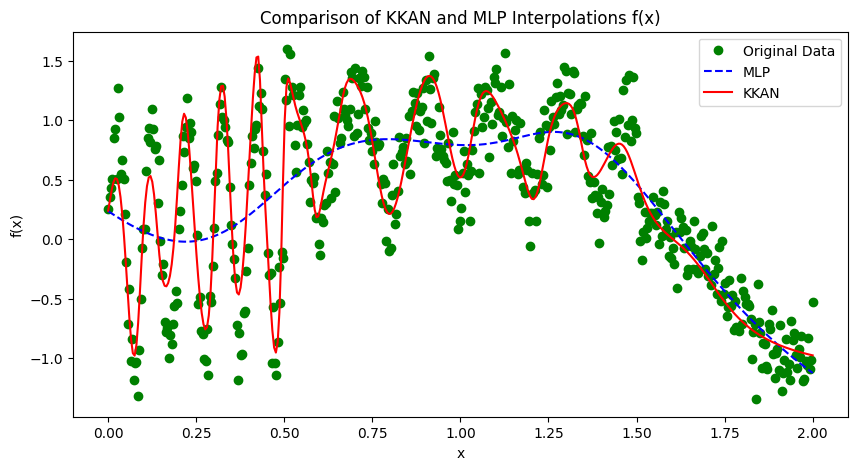

In [21]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_train.numpy(), y_train.numpy(), 'go', label='Original Data')
plt.plot(x_test.numpy(), y_pred_mlp.numpy(), 'b--', label='MLP')
plt.plot(x_test.numpy(), y_pred_kkan.numpy(), 'r', label='KKAN')
plt.title('Comparison of KKAN and MLP Interpolations f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

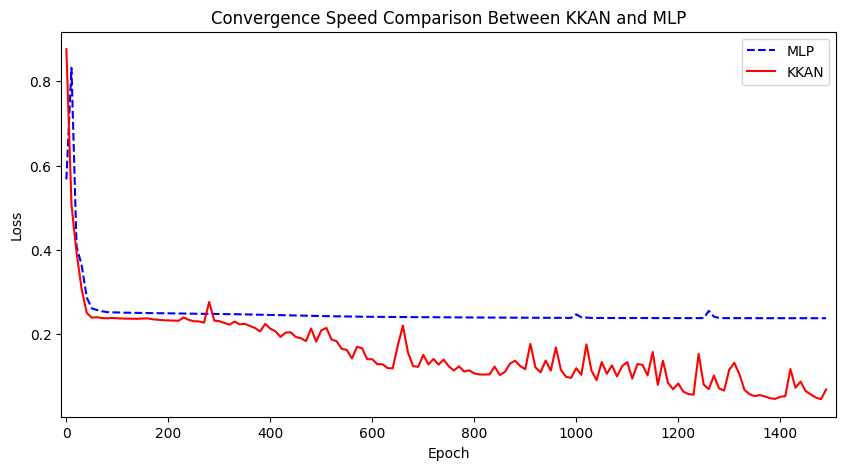

In [22]:
# Plot the convergence speed
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 10), mlp_losses, 'b--', label='MLP')
plt.plot(range(0, epochs, 10), kkan_losses, 'r', label='KKAN')
plt.title('Convergence Speed Comparison Between KKAN and MLP')
plt.xlim(-10, 1510)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()